In [2]:
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])

import warnings
warnings.filterwarnings('ignore')

Current conda environment: reinvent4


In [3]:
from posebusters import PoseBusters
from rdkit import Chem
from rdkit.Chem import PandasTools
import useful_rdkit_utils as uru
import mols2grid
from rdkit.Chem.Draw import MolsToGridImage
import pandas as pd
import seaborn as sns
import itertools 
from rdkit.Chem import rdMolAlign
from operator import itemgetter
from tqdm.auto import tqdm
from rdkit.Chem import AllChem

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [4]:
tqdm.pandas()

In [5]:
df_0 = PandasTools.LoadSDF("all.sdf")

[17:29:33] Explicit valence for atom # 23 C, 5, is greater than permitted
[17:29:33] ERROR: Could not sanitize molecule ending on line 27080
[17:29:33] ERROR: Explicit valence for atom # 23 C, 5, is greater than permitted
Failed to patch pandas - unable to change molecule rendering


First, we remove all of the generated molecules with more than 1 fragment. *(Why?)*

In [6]:
df_0['num_frags'] = df_0.ROMol.apply(uru.count_fragments)

In [7]:
df_0.num_frags.value_counts()

num_frags
1    953
2     45
3      1
Name: count, dtype: int64

In [8]:
df_1 = df_0.query("num_frags == 1").copy()

### Handling Duplicates

Here, we convert the molecules to InChI keys, which we will then use to identify duplicates. We store this in a new column of the pandas dataframe.

In [9]:
df_1['inchi'] = df_1.ROMol.apply(Chem.MolToInchiKey)

[17:29:34] unrecognized chirality tag (6) on atom 24 is ignored.


Using the InChI keys, we can show the 10 most frequently occuring molecules, as well as the number of times that structure was generated.

In [10]:
df_1.inchi.value_counts()[:10]

inchi
NMNAZPLXJFFRRP-UHFFFAOYSA-N    145
XBWWHXRTLPSFET-UHFFFAOYSA-N     39
YTMHLJOIUUEKMH-UHFFFAOYSA-N     21
KYSSITKIFJXDGP-UHFFFAOYSA-N     20
XNQMJMXXRBNEIG-UHFFFAOYSA-N     15
OVYIKDRTPAQVPP-UHFFFAOYSA-N     13
AXGBFDHSBIVXOT-UHFFFAOYSA-N     13
CAUKDXSOZCSYLQ-UHFFFAOYSA-N     13
BHHANBJKFBNEQA-UHFFFAOYSA-N     11
QMEBHAHLXVSXEX-UHFFFAOYSA-N     10
Name: count, dtype: int64

Here we create a new dataframe of only the most frequently generated molecule. Note that the InChI key only tells us information about the generated graph structure. However, the same generated molecule might still assume different poses and/or conformations in the binding site. In order to investigate this, we can calculate the root mean squared deviation (RMSD) between all pairs of generated molecules and examine the RMSD distribution.

In [11]:
df_freq = df_1.query("inchi == 'NMNAZPLXJFFRRP-UHFFFAOYSA-N'")

In [12]:
rms_list = []
for a,b in itertools.combinations(df_freq.ROMol,2):
    rms = AllChem.GetBestRMS(a,b)
    rms_list.append(rms)

In [13]:
sns.set(rc={'figure.figsize': (5, 5)})
sns.set_style('whitegrid')
sns.set_context('talk')

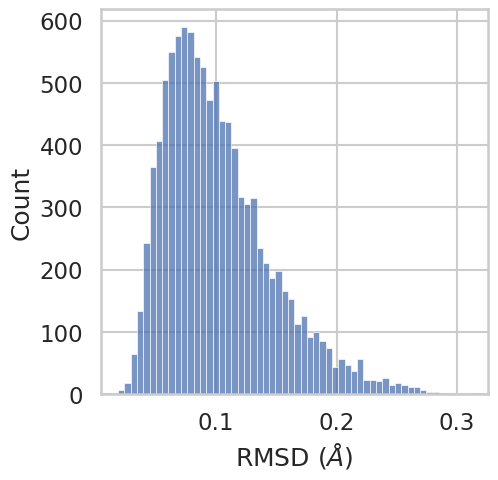

In [14]:
ax = sns.histplot(rms_list)
ax.set_xlabel("RMSD ($\AA$)");

Since the RMSD of each pair is less the 0.3, we observe that the generated poses and conformations are similar. Here, Pat mentions that he wrote out the 145 copies and visualized them in PyMol, verifying that the poses and conformations were the same. I have two questions at this point:

* What is the RMSD measuring between two molecules?
* What would be an example of a suffienctly large RMSD value to suspect that two InChI keys might correspond to molecules with different poses/conformations?

In [15]:
df_2 = df_1.drop_duplicates(subset="inchi").copy()

In [17]:
len(df_1),len(df_2)

(953, 537)

After removing the duplicates, we are left with  generated molecules. It would be an interesting exercise to visualize the molecules as Pat had, but probably not necessary.

### 

### Finding and Removing Molcules with Odd Ring Systems

Next, we are going to identify molecules with ring systems which are not chemically stable, as these will probably not be viable drug options. First we use the `RingSystemLookup` class from the `useful_rdkit_utils` toolkit, or `udu`.

In [20]:
ring_system_lookup = uru.RingSystemLookup.default()

Here, we are creating a new column in the dataframe called `ring_systems`. This stores information about the ring system which is retrieved from the RDKit `process_mol` function.

In [21]:
df_2['ring_systems'] = [list(ring_system_lookup.process_mol(x)) for x in df_2.ROMol]

Next, we create the columns `min_ring` and `min_freq`. These store the ring with the lowest frequency in the molecule and the specific frequency with which it appears in the ChEMBL databse, respectively.

In [22]:
df_2[['min_ring','min_freq']] = [list(uru.get_min_ring_frequency(x)) for x in df_2.ring_systems]

Here, we create a dataframe consisting of the molecules with odd ring systems and display them. Indeed, many of them look a little... funky.

In [30]:
odd_ring_df = df_2.query("min_freq < 100").drop_duplicates(subset="min_ring").sort_values("min_freq")
mols2grid.display(odd_ring_df, smiles_col="min_ring", subset=["img"],     
                  custom_css=""".data-mols2grid-id-display { display: none }""",
                 selection=False)

MolGridWidget()

Finally, we create a dataframe which consists of only the molecules which didn't contain any odd ring systems.

In [26]:
df_3 = df_2.query("min_freq >= 100").copy()

In [28]:
len(df_3)

393

We see that 144 of the generated molecules contained odd ring systems, and we are left with 393 molecules.

### Filtering Functional Groups

Many of the generated molecules contain chemically unstable functionality, e.g., reactivity, toxicity, or interference with biological assays. Our goal is to identify and remove these. To do so, we will use the `REOS` function in `useful_rdkit_utils`.

In [31]:
reos = uru.REOS()

We have several different classes of filters to choose from. Here, we examine how many molecules would remain in our dataset after being passed through each filter:

In [32]:
for rule_set in reos.get_available_rule_sets():
    reos.set_active_rule_sets([rule_set])
    if rule_set == "PW":
        reos.drop_rule("furans")
    reos_res = [reos.process_mol(x) for x in df_3.ROMol]
    reos_ok = [x for x in reos_res if x[0] == "ok"]
    print(rule_set, len(reos_ok))

Glaxo 354
Dundee 143
BMS 206
PAINS 385
SureChEMBL 309
MLSMR 223
Inpharmatica 314
LINT 300


We end up using the Dundee filter (because Pat likes it)

In [33]:
reos.set_active_rule_sets(["Dundee"])

Now we run the filter

In [34]:
df_3[['rule_set','reos']] = [list(reos.process_mol(x)) for x in df_3.ROMol]

We can display the reasons that each of the molecules were filtered out. For example, 130 molecules were filtered due to the so-called "het-C-het" rule, which corresponds to decomposition of the molecule under acidic conditions, which would be an undesirable property for a drug.

In [35]:
uru.value_counts_df(df_3,"reos")

,reos,count
0,ok,143
1,het-C-het not in ring,130
2,imine,42
3,Aliphatic long chain,19
4,acyclic C=C-O,17
5,isolated alkene,5
6,alkyl halide,5
7,Oxygen-nitrogen single bond,5
8,2-halo pyridine,4
9,aldehyde,3


We can visualize several of the molecules which violated the het-C-het rule. First, we create a list of the first six molecules in the dataset which violate this rule. Then, we assign 2D coordinates using rdkit's `Compute2DCoords()` function. This will make the visualizations look nicer. *Question: what was the format of the molecules before computing the 2D coordinates? A: An rdkit molecule object*

In [38]:
mol_list = df_3.query("reos == 'het-C-het not in ring'").head(6).copy().ROMol.values
[AllChem.Compute2DCoords(x) for x in mol_list];

Then, the following code:

* gets the SMARTS patterns for the "het-C-het not in ring" rule
* transforms the SMARTS patterns into molecules
* Finds matches for the six molecules according to the RDKit molecule object
* Displays violating molecules with the offending functionality highlighted

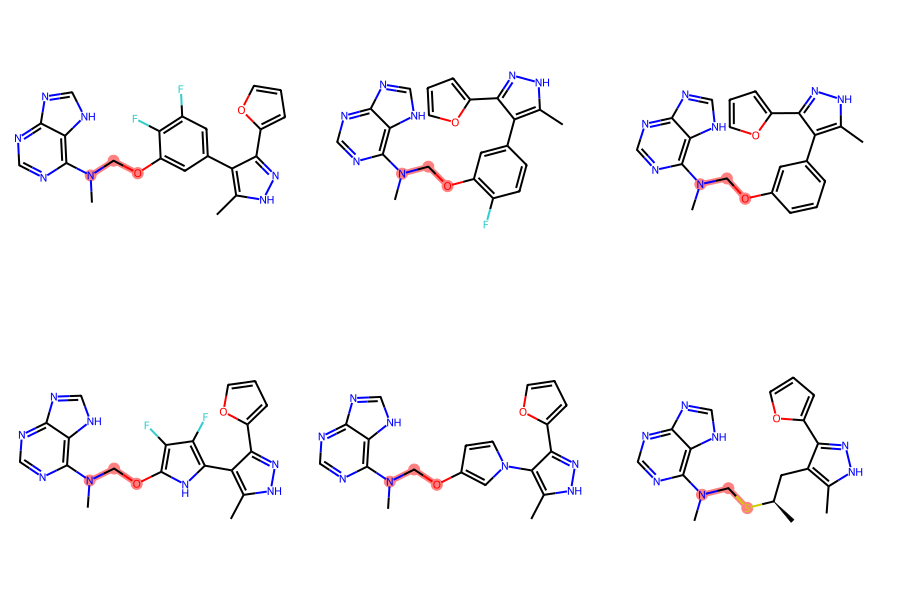

In [37]:
query_smarts = reos.active_rule_df.query("description == 'het-C-het not in ring'").smarts.values[0]
query_mol = Chem.MolFromSmarts(query_smarts)
match_atoms = [x.GetSubstructMatch(query_mol) for x in mol_list]
MolsToGridImage(mol_list,highlightAtomLists=match_atoms,subImgSize=(300, 300))

Now, we create a dataset consisting of the molecules which passed the Dundee filter

In [41]:
df_4 = df_3.query("reos == 'ok'").copy()

We can visualize our remaining molecules:

In [46]:
mols2grid.display(df_4,mol_col="ROMol",size=(170, 170))

MolGridWidget()

### Filtering Bad Geometries w/ PoseBusters

In [48]:
%%time
pb = PoseBusters(config="dock")
bust_df = pb.bust(df_4.ROMol, None, "3hz1_protein.pdb")

Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File does not exist
Could not load molecule from 3hz1_protein.pdb with error: File d

KeyboardInterrupt: 